## Toric code data generation:
You can ignore this file if you already have data.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

direction='in'
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import rc
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : direction ,
    'ytick.direction' : direction ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 2,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import bson
from bson import BSON
import struct
from scipy import interpolate

In [4]:
def is_non_zero_file(fpath, verb=False):
    if verb: 
        if os.path.isfile(fpath)==False: print('No', fpath)
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0

In [5]:
def num2bin(num):
    a = list(format(num-1, 'b').zfill(2))
    return int(a[0]), int(a[1])

def twoqubit2onequbit(A, order=1):
    B = np.empty((A.shape[0]*2, A.shape[1]*2))
    B[:] = None
    for ia, ib in enumerate(np.arange(A.shape[0])*2):
        for ja, jb in enumerate(np.arange(A.shape[1])*2):
            if order==1:
                B[ib, jb+1], B[ib+1, jb] = num2bin(A[ia, ja])
            else:
                B[ib+1, jb], B[ib, jb+1] = num2bin(A[ia, ja])
                
    return B

def make_array(B, pt): #pt: loc of leftmost point of 6x6 array
    pt0, pt1 = pt
    C = np.empty(nr*nc)
    C[:] = None
    k = 0
    for i in range (nr):
        for j in range (nc):
            pt0_, pt1_ = pt0+i-j, pt1+i+j
            C[k] = B[pt0_, pt1_]
            k += 1
    if not np.any(np.isnan(C)):
        return C
    else: return None
    
def check_point(pt, cut=600):
    pt0, pt1 = pt
    up0, up1 = pt0-5, pt1+5
    dn0, dn1 = pt0+5, pt1+5
    rt0, rt1 = pt0, pt1+10
    checkx = np.array([pt0, up0, dn0, rt0])
    checky = np.array([pt1, up1, dn1, rt1])
    if ((checkx>=0) * (checkx<cut)).all():
        if ((checky>=0) * (checky<2000)).all():
            return pt
        else: return False
    else: return False
    
def bitflip(B, pflip):
    for i in range (B.shape[0]):
        for j in range (B.shape[1]):
            if np.isnan(B[i,j]): continue
            else:
                if np.random.uniform()<=pflip: B[i,j] = (B[i,j]+1)%2
                else: continue
    return B
def check_parity(B, Z=True):
    B = 2*B - 1
    parity = np.ones_like(B)*-100
    
    if Z==True:
        for ii in (np.arange(B.shape[0])[1::2][:-1]):
            for jj in (np.arange(B.shape[1])[1::2][:-1]):
                up = (ii-1, jj)
                dn = (ii+1, jj)
                lf = (ii, jj-1)
                rg = (ii, jj+1)
                parity[ii,jj] = B[up]*B[dn]*B[lf]*B[rg]
    else:
        for ii in (np.arange(B.shape[0])[::2][:-1]):
            for jj in (np.arange(B.shape[1])[::2][:-1]):
                up = (ii-1, jj)
                dn = (ii+1, jj)
                lf = (ii, jj-1)
                rg = (ii, jj+1)
                parity[ii,jj] = B[up]*B[dn]*B[lf]*B[rg]
    return (parity+1)//2
def check_parity_36(array):
    array = array*2-1
    points = []
    for i in [0,2,4]:
        for j in [0,2,4]:
            points.append((i,j))
    for i in [1,3]:
        for j in [1,3]:
            points.append((i,j))
    
    parity = np.ones(13)*-100
    for i, pt0 in enumerate(points):
        pt1 = (pt0[0]+1, pt0[1])
        pt2 = (pt0[0], pt0[1]+1)
        pt3 = (pt0[0]+1, pt0[1]+1)
        parity[i] = array[pt0]*array[pt1]*array[pt2]*array[pt3]
    return ((parity+1)//2).mean()

points = []
cut = 300
for n in range ( int((1000+cut)*2 / 12) ): # (1000+250)*2 / 12
    for m in range (2*n+1):
        pt = (5+6*m, 12*n-6*m)
        if check_point(pt, 2*cut): points.append(check_point(pt, 2*cut))
print(len(points), len(points)*58)

def blockshaped(arr, nrows, ncols):
    h, w = arr.shape
    if not h % nrows == 0: 
        arr = arr[:h-h%nrows]
        h, w = arr.shape
    if not w % ncols == 0:
        arr = arr[:,:w-w%ncols]
        h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

16434 953172


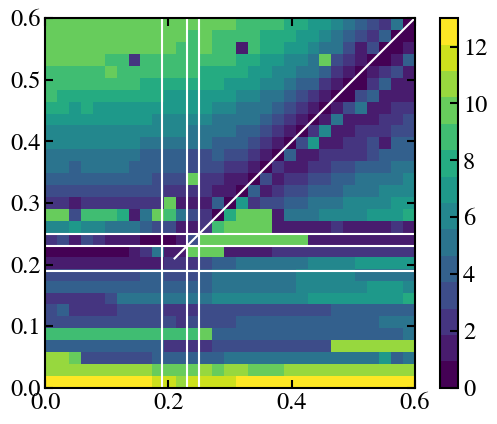

In [26]:
array_bxbz = np.linspace(0, 0.6, 31)
array = np.zeros((len(array_bxbz),len(array_bxbz)))

for i, bx in enumerate (array_bxbz):
    for j, bz in enumerate (array_bxbz):
        a = 0
        if i%5==0: bx_ = f'{bx:.1f}'
        else: bx_ = f'{bx:.2f}'
        if j%5==0: bz_ = f'{bz:.1f}'
        else: bz_ = f'{bz:.2f}'
        for run in range(1,15):
            filename = '../Data_src/toric_code/data/sims/tc/PEPS/' \
                        +f'betaX={bx_}_betaZ={bz_}_height=300_run={run}_width=1000.bson'
            if not is_non_zero_file(filename): continue
            a += 1
        array[i,j] = a
im = plt.imshow(array, origin='lower', extent=[0,0.6,0,0.6], cmap=mpl.cm.get_cmap('viridis', 14))
plt.plot(np.linspace(0.21, 0.6, 7), np.linspace(0.21, 0.6, 7), c='w')
plt.axvline(0.19, c='w')
plt.axvline(0.23, c='w')
plt.axvline(0.25, c='w')
plt.axhline(0.19, c='w')
plt.axhline(0.23, c='w')
plt.axhline(0.25, c='w')
plt.colorbar(im)

In [ ]:
nr, nc = 6, 6
dir_name = f'../Data_src/toric_code/data'

for k, pflip in enumerate(np.arange(1,65)*0.005):
    os.makedirs(dir_name+f'{nr*nc}/dual_pflip_{pflip:.3f}',exist_ok=True)
    for i, bx in enumerate(np.arange(20)*0.02):
        bz = 0.14
        for run in range(1,15):
            if i%5==0: bx_ = f'{bx:.1f}'
            else: bx_ = f'{bx:.2f}'
            filename = dir_name+'/sims/tc/PEPS/' \
                        +f'betaX={bx_}_betaZ={bz:.2f}_height=300_run={run}_width=1000.bson'
            if not is_non_zero_file(filename): continue
            with open(filename,'rb') as f:
                data = bson.decode_all(f.read())
            string = data[0]['samps']['data']
            array_string = np.array(list(string)[::8]).reshape(1000, 300)
            B = twoqubit2onequbit(array_string).T
            if pflip!=0: B = bitflip(B, pflip)
            parity = check_parity(B)
            save_filename = dir_name+f'{nr*nc}/dual_pflip_'\
                        +f'{pflip:.3f}/betaX={bx:.2f}_betaZ={bz:.2f}_height=300_run={run}_width=1000.npz'
            np.savez(save_filename, arr0 = parity[parity>-10].reshape(299,999))
            print(pflip, bx, bz, run)

In [ ]:
# Training data
for k, pflip in enumerate(np.array([0.000,0.300])):
    os.makedirs(dir_name+f'{nr*nc}/training_pflip_{pflip:.3f}',exist_ok=True)
    trainnum=0
    for i, bx in enumerate(np.arange(5)*0.02):
        bz = 0.14
        for j, pflipextend in enumerate(np.arange(5)*0.005):
            for run in range(1,15):
                filename = dir_name +f'{nr*nc}/dual_pflip_{pflip+pflipextend:.3f}'\
                            +f'/betaX={bx:.2f}_betaZ={bz:.2f}_height=300_run={run}_width=1000.npz'
                if not is_non_zero_file(filename): continue
                data = np.load(filename)['arr0']
                data = blockshaped(data, nr, nc)
                save_filename = dir_name+f'{nr*nc}/training_pflip_{pflip:.3f}'\
                            +f'/trainnum{trainnum:d}.npz'
                np.savez(save_filename, arr0 = data)
                trainnum+=1
                print(bx, run)
    print(trainnum) # = 200

In [ ]:
# Testing data
print(nr, nc)
for k, pflip in enumerate(np.arange(65)*0.005):
    os.makedirs(dir_name+f'/testing_pflip_{pflip:.3f}',exist_ok=True)
    for i, bx in enumerate(np.arange(20)*0.02):
        bz = 0.14
        for run in range(1,15):
            if i%5==0: bx_ = f'{bx:.1f}'
            else: bx_ = f'{bx:.2f}'
            filename = dir_name +f'{nr*nc}/dual_pflip_{pflip:.3f}'\
                            +f'/betaX={bx:.2f}_betaZ={bz:.2f}_height=300_run={run}_width=1000.npz'
            if not is_non_zero_file(filename): continue
            data = np.load(filename)['arr0']
            data = blockshaped(data, nr, nc)
            save_filename = dir_name+f'{nr*nc}/testing_pflip_'\
                        +f'{pflip:.3f}/betaX={bx:.2f}_betaZ={bz:.2f}_height=300_run={run}_width=1000.npz'
            np.savez(save_filename, arr0 = data)
            print(pflip, bx, bz, run)